In [1]:
import pandas as pd
import numpy as np

import pandas as pd
import numpy as np

from IPython.display import HTML

import latools as la

from comparison_tools import helpers, stats, plots

%matplotlib inline

The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.


## Data Collection Parameters

In [2]:
HTML(filename="./Parameter_Tables/cultured_forams.html")

**NB**: Per-element dwell times not recorded.

## Process Data

In [3]:
dat = la.analyse('raw_data/cultured_foram/', srm_identifier='STD')

Starting analysis using "UCD-AGILENT" configuration:
  27 Data Files Loaded: 2 standards, 25 samples
  Analytes: B11 Mg24 Mg25 Al27 Ca43 Ca44 Sr86 Sr87 Sr88 Ba138
  Internal Standard: Ca43


In [4]:
dat.basic_processing(despike_win=5,
                     autorange_on_mult=[2, 1], autorange_off_mult=[1, 2],
                     bkg_weight_fwhm=800, bkg_n_min=60, bkg_filter=True, bkg_f_n_lim=3, bkg_cstep=300,
                     calib_srms_used=['NIST610', 'NIST612', 'NIST614'], calib_drift_correct=True,
                     plots=False)

Applying Calibrations: 100%|██████████| 27/27 [00:02<00:00, 10.69it/s]


In [5]:
dat.calibrate(['B11', 'Mg24', 'Mg25', 'Sr87'], srms_used=['NIST610', 'NIST612', 'NIST614'],
              drift_correct=True, zero_intercept=False)

Applying Calibrations: 100%|██████████| 27/27 [00:01<00:00, 15.76it/s]


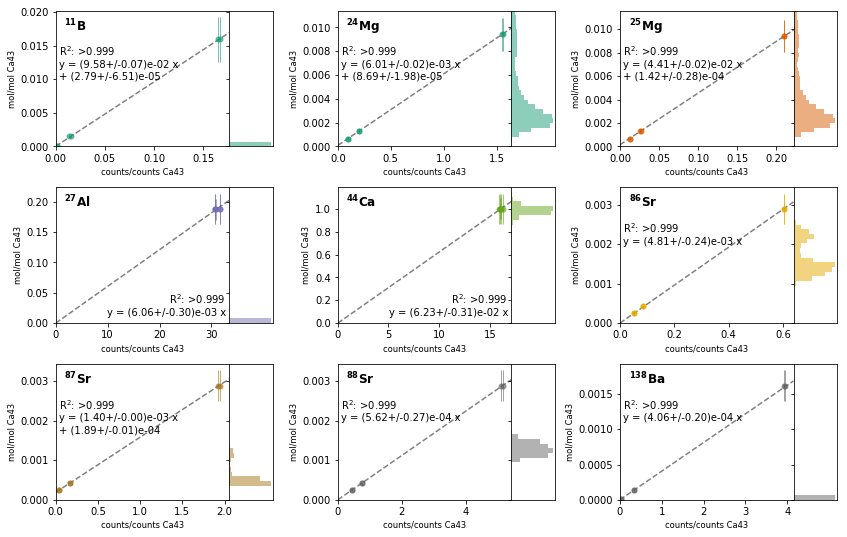

In [6]:
fig, axs = dat.calibration_plot()

### Filtering

In [7]:
dat.filter_clear()

In [8]:
# subsets
dat.make_subset([s for s in dat.samples if (s[0] == 'B') | (s[0] == 'C') | (s[0] == 'E')], 'dut')
dat.make_subset([s for s in dat.samples if (s[0] != 'B') & (s[0] != 'C') & (s[0] != 'E') & (s[0] != 'S')], 'orb')

'orb'

In [9]:
dat.filter_clear(subset='orb')
dat.filter_threshold('Al27', 0.1e-3, subset='orb')
dat.filter_on('below', subset='orb', show_status=True)

Threshold Filter: 100%|██████████| 6/6 [00:00<00:00, 3645.11it/s]

Subset: orb
Samples: LN1_A, LN3_A, LN4_A, LN5_A, JF2-A_A, AR5-8A

n  Filter Name          B11    Mg24   Mg25   Al27   Ca43   Ca44   Sr86   Sr87   Sr88   Ba138  
0  Al27_thresh_below    True   True   True   True   True   True   True   True   True   True   
1  Al27_thresh_above    False  False  False  False  False  False  False  False  False  False  



In [10]:
dat.filter_clear(subset='dut')
dat.filter_threshold('Al27', 0.1e-3, subset='dut')
dat.filter_threshold('Ba138', 6e-6, subset='dut')
dat.filter_threshold('Mg24', 15e-3, subset='dut')
dat.filter_on('Ba138_thresh_below', subset='dut')
dat.filter_on('below', subset='dut', show_status=True)

Threshold Filter: 100%|██████████| 19/19 [00:00<00:00, 2057.89it/s]

Subset: dut
Samples: C3_A, C3-F_A, C1-F_A, C4-F_A, C4-F1_A, C5-F1_A, C7-F_A, C8-F_A, C9-F_A, E6-F1_A, E7-F_A, E9-F_A, B12-F_A, B11-F_A, B10-F_A, B10-F1_A, B8-F_B, B3-F_A, B4-F_A

n  Filter Name           B11    Mg24   Mg25   Al27   Ca43   Ca44   Sr86   Sr87   Sr88   Ba138  
0  Al27_thresh_below     True   True   True   True   True   True   True   True   True   True   
1  Al27_thresh_above     False  False  False  False  False  False  False  False  False  False  
2  Ba138_thresh_below    True   True   True   True   True   True   True   True   True   True   
3  Ba138_thresh_above    False  False  False  False  False  False  False  False  False  False  
4  Mg24_thresh_below     True   True   True   True   True   True   True   True   True   True   
5  Mg24_thresh_above     False  False  False  False  False  False  False  False  False  False  



In [11]:
dat.sample_stats(stats=['mean', 'std', 'stderr'])

Calculating Stats: 100%|██████████| 27/27 [00:00<00:00, 78.15it/s]


In [12]:
ld = dat.getstats().loc['mean'] * 1e3

## Compare Data

In [13]:
rd = helpers.load_reference_data('culture_reference')
td = helpers.load_reference_data('culture_test')
# ld = helpers.read_latools_data('Jenn_Data_export/clean_Alfilt.csv')

# combine all data
df = rd.join(td, lsuffix='_r', rsuffix='_t')
df = df.join(ld)

In [14]:
# number of unique samples
np.unique(rd.index.levels[0]).size

33

## Characterise Inter-Replicate Reproducibility

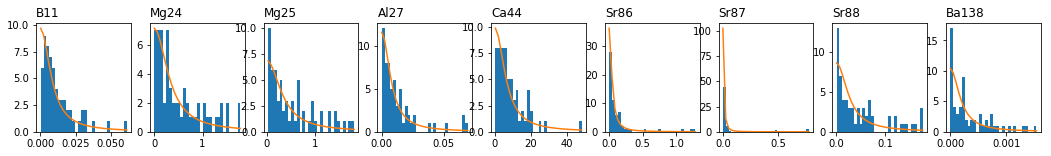

In [15]:
_ = stats.pairwise_reproducibility(ld, plot=True)

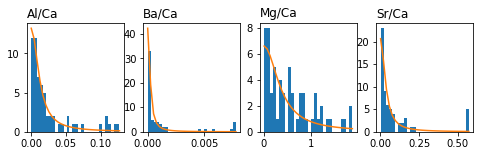

In [16]:
_ = stats.pairwise_reproducibility(td, plot=True)

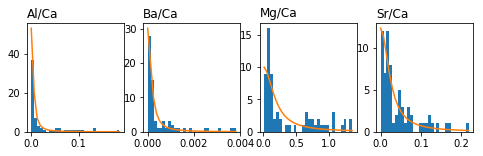

In [17]:
_, rep_dists, rep_stats, _ = stats.pairwise_reproducibility(rd, plot=True)

In [18]:
rep = pd.DataFrame(rep_stats).T
rep.columns = ['50%', '95%']
rep = rep.loc[['Mg/Ca', 'Sr/Ca', 'Ba/Ca', 'Al/Ca'],:]

In [19]:
rep.to_csv('reproducibility_quants.csv')

## Compare Data

In [20]:
# fig, axs = plots.comparison_plots(df, els=['Mg', 'Sr', 'Ba', 'Al'])

In [21]:
# fig, axs = plots.residual_plots(df, rep_stats, els=['Mg', 'Sr', 'Ba', 'Al'])

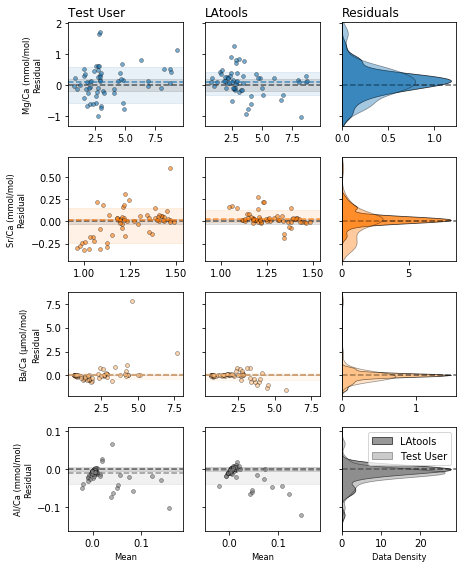

In [22]:
fig, axs = plots.bland_altman_plots(df, rep_stats=rep_stats, els=['Mg', 'Sr', 'Ba', 'Al'])

fig.savefig('Figures/culture_comparison.pdf')
fig.savefig('Figures/culture_comparison.png', dpi=200)

## Comparison Stats

In [23]:
stat = stats.comparison_stats(df, els=['Mg', 'Sr', 'Ba', 'Al'])

In [24]:
stat.to_csv('Stats/culture_stats.csv')

In [25]:
stat['Test User']

Residual Summary                                                \
                     N      Median         LQ        IQR          UQ   
Mg/Ca               58    0.110929  -0.209317   0.589884    0.380567   
Sr/Ca               58   0.0126133  -0.134795    0.19071    0.055915   
Ba/Ca               58 -0.00175805  -0.173678   0.237852    0.064174   
Al/Ca               58 -0.00979209 -0.0191629  0.0137064 -0.00545648   

      Residual Regression                                                  \
                    Slope    Slope t      Slope p   Intercept Intercept t   
Mg/Ca           0.0251354    0.75898     0.451047   0.0071223   0.0524345   
Sr/Ca          -0.0109954 -0.0616828     0.951035 -0.00204797 -0.00913788   
Ba/Ca           0.0401601   0.362272     0.718513   0.0548817     0.19363   
Al/Ca           -0.354314   -6.10224  1.03594e-07  -0.0062644    -2.24782   

                               Kolmogorov-Smirnov               
      Intercept p           R2                 KS            p  
Mg/Ca    0.958369    0.0101819           0.137931     0.606755  
Sr/Ca    0.992742  6.79377e-05           0.189655     0.222094  
Ba/Ca    0.847166    0.0023381           0.137931     0.606755  
Al/Ca   0.0285442     0.399382           0.517241  1.60669e-07

In [26]:
stat['LAtools']

Residual Summary                                                 \
                     N      Median          LQ        IQR          UQ   
Mg/Ca               59    0.114496   -0.107672   0.381096    0.273424   
Sr/Ca               59   0.0234462 -0.00188167  0.0422219   0.0403403   
Ba/Ca               59      0.0233   -0.044845   0.141585   0.0967396   
Al/Ca               59 -0.00103241  -0.0108748  0.0134093  0.00253445   

      Residual Regression                                                \
                    Slope  Slope t      Slope p   Intercept Intercept t   
Mg/Ca          -0.0677251 -2.75275   0.00791297    0.326237     3.24485   
Sr/Ca           -0.352451 -5.82599  2.76776e-07    0.471439     6.21919   
Ba/Ca           -0.193085 -5.51498  8.82499e-07    0.377891     4.21415   
Al/Ca           -0.479966 -11.9848   3.2775e-17  0.00105801    0.554612   

                             Kolmogorov-Smirnov             
       Intercept p        R2                 KS          p  
Mg/Ca   0.00196848  0.117341           0.135593   0.617954  
Sr/Ca  6.27717e-08  0.373228           0.237288  0.0606463  
Ba/Ca  9.03892e-05  0.347938           0.118644   0.774714  
Al/Ca      0.58133  0.715904           0.237288  0.0606463